In [56]:
from pathlib import Path
import requests
import matplotlib.pyplot as plt
import numpy as np
import random 

import torch
import torch.nn.functional as F
import torch.nn as  nn

In [2]:
data_dir = Path('/Users/djemec/data/gpt_train_data/')
#dest = data_dir / 'tiny_shakespeare' / 'input.txt'
names_url = "https://github.com/karpathy/makemore/raw/refs/heads/master/names.txt"
dest = data_dir / 'names' / 'names.txt'
#dest.write_bytes(requests.get(names_url, timeout=30).content)

In [36]:
block_size = 3 # context window
n_embd = 15 # dimensionality of embedding space
n_hidden = 250 # neurons in hidden layer
num_layers = n_embd * block_size

random.seed(123)
g = torch.Generator().manual_seed(12345678)

In [37]:
# read all words in
# remove empty lines and makes all things lower case
with open(dest) as f:
    words = [ln.rstrip('\n').lower() for ln in f if ln.strip()]

words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [38]:
# *lines forces character level
stop_char = '.'
chars = sorted(list(set().union(*words)) + [stop_char])
vocab_size = len(chars) 

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

print(f'total vocab {vocab_size} | chars: {itos}') 

total vocab 27 | chars: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [43]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + stop_char:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y


random.shuffle(words)

n1 = int(0.8*len(words)) # first 80%
n2 = int(0.9*len(words)) # first 90% so this minus 80% gives 10%

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182412, 3]) torch.Size([182412])
torch.Size([22949, 3]) torch.Size([22949])
torch.Size([22785, 3]) torch.Size([22785])


In [47]:
C = torch.randn((vocab_size,n_embd), generator=g)
# hidden layers
W1 = torch.randn((num_layers, n_hidden), generator=g) * (5/3) / num_layers**0.5 # squash weights by doing weight/sqrt(fan_in)
#b1 = torch.randn(n_hidden, generator=g) * 0.001 # don't need since batch normalized
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # downweight to reduce randomness at initialization
b2 = torch.randn(vocab_size, generator=g) * 0  # one for each vocab
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.ones((1,n_hidden))
bnstd_running = torch.zeros((1,n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]

print('parameters: ',sum(p.nelement() for p in parameters))
# requres grad:
for p in parameters:
    p.requires_grad = True

parameters:  18932


In [48]:
lossi = []
learning_rate = 0.01
batch_size = 64
max_steps = 200000

batch normalization is sprinkled throughout the layers to help normalize the weights

In [49]:
for i in range(max_steps):
    # initiate batch size
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into vector
    embcat = emb.view(emb.shape[0],-1) # concats the vectors to the hidden layer shape
    hpreact = embcat @ W1 #+ b1 don't need bias

    # batch norm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization, normalizes on std dev
    ## calibrated batch normalization
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani # minor nudge based on mean to calcualte global mean in parallel
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi # minor nudge based on mean to calcualte global mean in parallel
        
    # hidden layer
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None 
    loss.backward() 

    # update with learning rate decay
    lr = learning_rate if i < 100000 else lr/(round(i/10000.0))
    for p in parameters:
        p.data += -lr * p.grad
    
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2979
  10000/ 200000: 2.2316
  20000/ 200000: 2.1777
  30000/ 200000: 2.1409
  40000/ 200000: 2.6424
  50000/ 200000: 2.2415
  60000/ 200000: 2.1704
  70000/ 200000: 2.2881
  80000/ 200000: 2.1532
  90000/ 200000: 2.3582
 100000/ 200000: 2.3302
 110000/ 200000: 2.2011
 120000/ 200000: 2.1784
 130000/ 200000: 1.9893
 140000/ 200000: 2.2637
 150000/ 200000: 2.1496
 160000/ 200000: 1.8288
 170000/ 200000: 2.0821
 180000/ 200000: 1.8824
 190000/ 200000: 2.0136


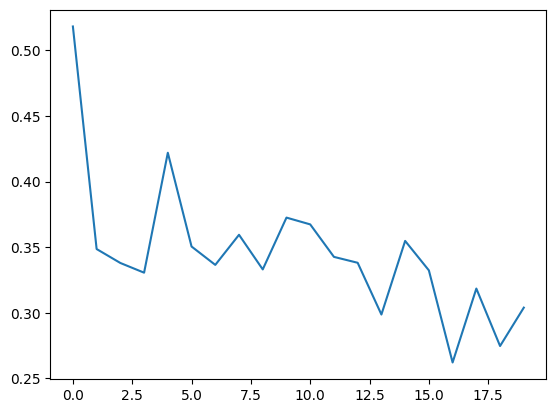

In [50]:
plt.plot(lossi[::10000])

#### Neuron quality assessment
if hidden layer is -1 or 1 for all of the weights, the backward pass won't adjust the weight as the gradient becomes 0. This can mean that learning is capped.  we can see this by visualizing h and seeing if the absolute value for most/all of the weights is >.99 

Can also kill a neuron if your learning rate is too high 

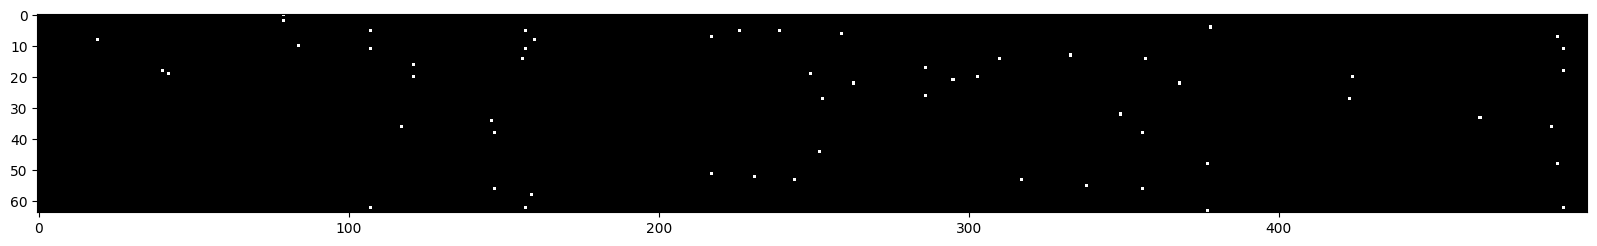

In [108]:
# # this was run after we squashed the first neuron. see the difference in the lack of dead neurons
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

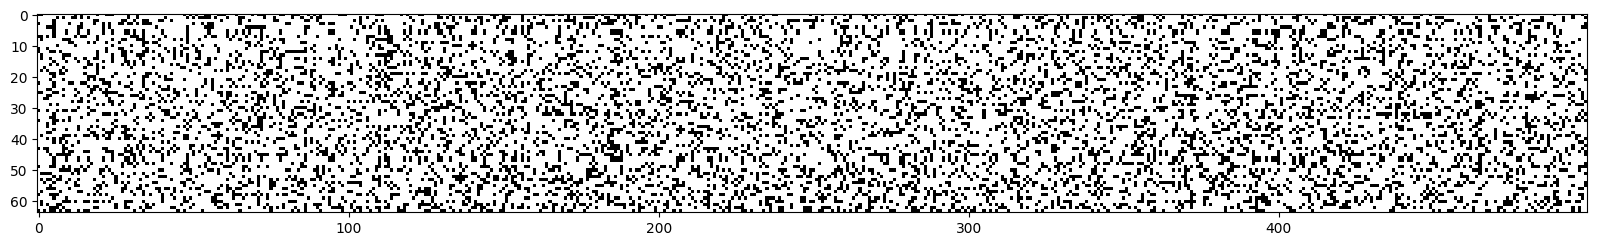

In [101]:
# this was run before we squashed the first neuron. 
#plt.figure(figsize=(20,10))
#plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# if a column is fully white then the neuron is dead.

## Calculate Loss

In [51]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1) 
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # based on calibrated mean std
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

_ = [split_loss(i) for i in ['train','val','test']]

train 2.136558771133423
val 2.157078504562378
test 2.1696410179138184


## Sample

In [52]:
g = torch.Generator().manual_seed(12345678 + 10)

examples = 20 
for i in range(examples):
    out = []
    context = [0] * block_size
    while True:

        emb = C[torch.tensor([context])] 
        hpreact = emb.view(1,-1) @ W1 #+ b1 # hidden layer pre-activation
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # based on calibrated mean std
        h = torch.tanh(hpreact) # hidden layer

        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break on sampled special token
        if ix==0:
            break

    print(''.join([itos[i] for i in out]))
            
        

quavanci.
tori.
ler.
ahisa.
wwidy.
amiya.
ollynne.
yanna.
jorley.
kashmilcon.
alynn.
gryce.
trimiah.
kol.
divos.
kaleena.
romance.
ausiah.
ari.
daryafnan.


## Goal loss
initial goal loss should be close to random, so if you have 27 characters should have initial loss close to 
-ln(1/27) ~ 3.295

## Activation functions
dead neuron if all weights in a flat region 
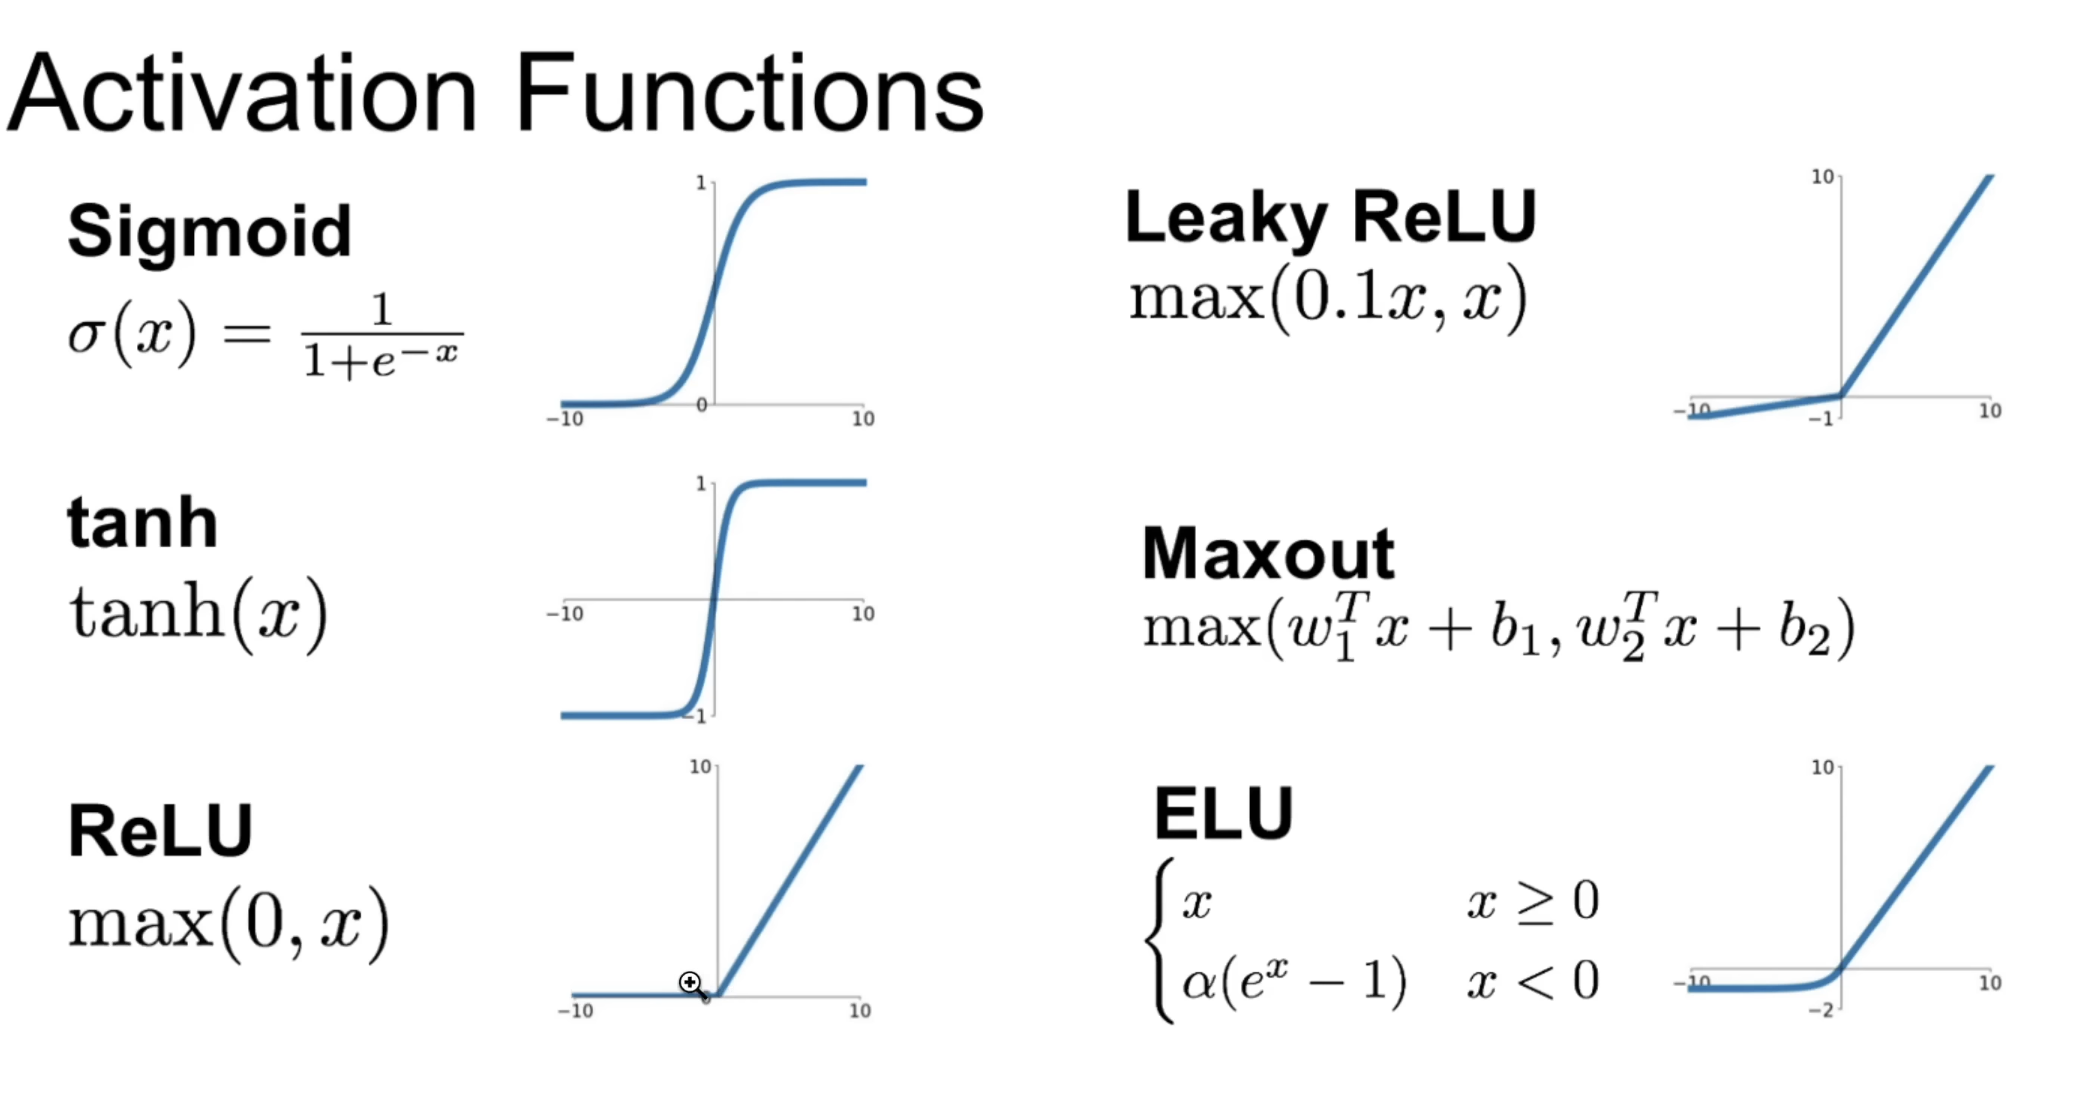

## Pytorch Based Implementation

In [67]:
block_size = 3 # context window

random.seed(123)

In [68]:
# *lines forces character level
stop_char = '.'
chars = sorted(list(set().union(*words)) + [stop_char])
vocab_size = len(chars) 

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

print(f'total vocab {vocab_size} | chars: {itos}') 

total vocab 27 | chars: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [69]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + stop_char:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y


random.shuffle(words)

n1 = int(0.8*len(words)) # first 80%
n2 = int(0.9*len(words)) # first 90% so this minus 80% gives 10%

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182496, 3]) torch.Size([182496])
torch.Size([22855, 3]) torch.Size([22855])
torch.Size([22795, 3]) torch.Size([22795])


In [142]:
# structure like torch
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return[self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [143]:
n_embd = 10 # dimensionality of embedding space
n_hidden = 100 # neurons in hidden layer
num_layers = n_embd * block_size
g = torch.Generator().manual_seed(12345678)

In [144]:
C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(num_layers, n_hidden), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size, momentum=0.001),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain, removed because of batch normalization
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47551


In [145]:
lossi = []
learning_rate = 1.0
batch_size = 32
max_steps = 200000

In [146]:
for i in range(max_steps):
    # min batch construction
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into vector
    x = emb.view(emb.shape[0],-1) # concats the vectors to the hidden layer shape
    for layer in layers: # calls each layer to froce the __call__ function
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # only here for debugging
    for p in parameters:
        p.grad = None 
    loss.backward() 

    # update with learning rate decay
    lr = learning_rate if i < 100000 else lr/(round(i/10000.0))
    for p in parameters:
        p.data += -lr * p.grad
    
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    


      0/ 200000: 3.3042
  10000/ 200000: 2.1926
  20000/ 200000: 1.7532
  30000/ 200000: 2.0412
  40000/ 200000: 2.0140
  50000/ 200000: 2.4660
  60000/ 200000: 1.9114
  70000/ 200000: 1.7971
  80000/ 200000: 1.6392
  90000/ 200000: 1.7715
 100000/ 200000: 1.8987
 110000/ 200000: 2.0093
 120000/ 200000: 2.0718
 130000/ 200000: 2.2506
 140000/ 200000: 1.9761
 150000/ 200000: 2.5603
 160000/ 200000: 2.2573
 170000/ 200000: 2.8922
 180000/ 200000: 2.3031
 190000/ 200000: 2.1537


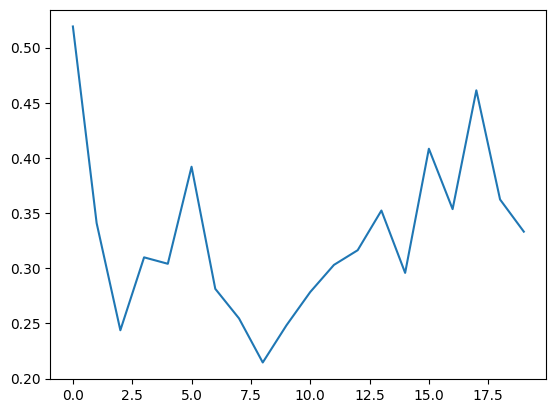

In [147]:
plt.plot(lossi[::10000])

## PyTorch version

In [149]:
C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    nn.Linear(num_layers, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size), nn.BatchNorm1d(vocab_size, momentum=0.001),
]


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


47551


In [151]:
for i in range(100000):
    # min batch construction
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed chars into vector
    x = emb.view(emb.shape[0],-1) # concats the vectors to the hidden layer shape
    for layer in layers: # calls each layer to froce the __call__ function
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    
    # backward pass
    for p in parameters:
        p.grad = None 
    loss.backward() 

    # update with learning rate decay
    lr = learning_rate if i < 100000 else lr/(round(i/10000.0))
    for p in parameters:
        p.data += -lr * p.grad
    
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    


      0/ 200000: 3.9250
  10000/ 200000: 2.0787
  20000/ 200000: 2.1184
  30000/ 200000: 1.7953
  40000/ 200000: 2.0871
  50000/ 200000: 2.0936
  60000/ 200000: 2.2659
  70000/ 200000: 2.0990
  80000/ 200000: 2.0616
  90000/ 200000: 2.7219


## Making a wavenet / RNN
the goal is to take a longer context 

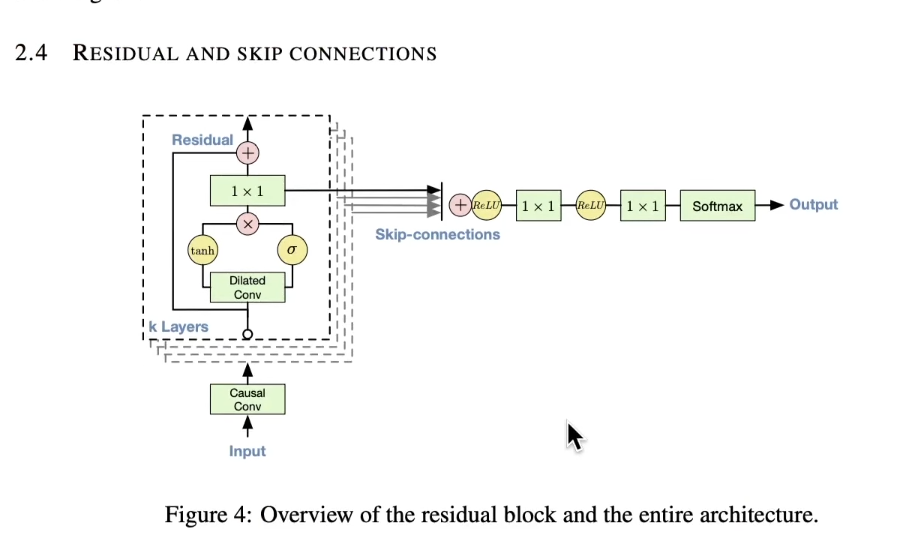

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
import random

In [25]:
data_dir = Path('/Users/djemec/data/gpt_train_data/')
dest = data_dir / 'names' / 'names.txt'

block_size = 8 # context window
random.seed(123)

In [26]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + stop_char:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y


In [60]:
with open(dest) as f:
    words = [ln.rstrip('\n').lower() for ln in f if ln.strip()]

# *lines forces character level
stop_char = '.'
chars = sorted(list(set().union(*words)) + [stop_char])
vocab_size = len(chars) 

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

print(f'total vocab {vocab_size} | chars: {itos}') 

total vocab 27 | chars: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [61]:
random.shuffle(words)

n1 = int(0.8*len(words)) # first 80%
n2 = int(0.9*len(words)) # first 90% so this minus 80% gives 10%

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xval, Yval = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182416, 8]) torch.Size([182416])
torch.Size([22827, 8]) torch.Size([22827])
torch.Size([22903, 8]) torch.Size([22903])


In [62]:
# structure like torch
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
        
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate forward pass
        dim = 0 if x.ndim == 2 else (0,1)
        if self.training:
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return[self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
            
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [63]:
torch.manual_seed(42)
n_embd = 24 # dimensionality of embedding space
n_hidden = 128 # neurons in hidden layer
num_layers = n_embd * block_size

### Pytorch containers
pytorch containers allow you to maintain layers together in a specific order of operations

In [64]:

model = Sequential([
    Embedding(vocab_size,n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden, momentum=0.001), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


76579


In [77]:
lossi = []
learning_rate = 0.1
batch_size = 32
max_steps = 200000

In [78]:
for i in range(max_steps):
    # min batch construction
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logist = model(Xb)
    loss = F.cross_entropy(logist, Yb) # loss function

    
    # backward pass
    for p in parameters:
        p.grad = None 
    loss.backward() 

    # update with learning rate decay
    lr = learning_rate if i < 150000 else learning_rate/(round(i/10000.0))
    for p in parameters:
        p.data += -lr * p.grad
    
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())    


      0/ 200000: 1.6293
  10000/ 200000: 1.7065
  20000/ 200000: 2.1556
  30000/ 200000: 1.4679
  40000/ 200000: 1.5623
  50000/ 200000: 1.4528
  60000/ 200000: 2.0343
  70000/ 200000: 1.9733
  80000/ 200000: 1.7765
  90000/ 200000: 1.8953
 100000/ 200000: 1.7062
 110000/ 200000: 1.7622
 120000/ 200000: 1.6364
 130000/ 200000: 1.9571
 140000/ 200000: 1.7512
 150000/ 200000: 1.6288
 160000/ 200000: 1.6780
 170000/ 200000: 1.8884
 180000/ 200000: 2.0620
 190000/ 200000: 1.7244


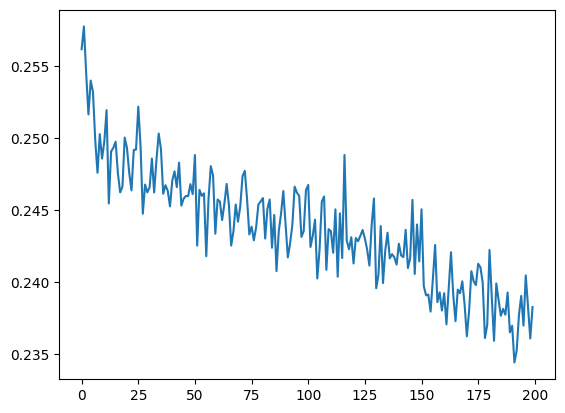

In [83]:
# make loss average over each 1000
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [84]:
# put layers in eval mode
for layer in model.layers:
    layer.training = False

In [85]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())

_ = [split_loss(i) for i in ['train','val','test']]

train 1.7471541166305542
val 2.0370571613311768
test 2.0304369926452637


In [86]:
num_examples = 20
for i in range(num_examples):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))
    
    

maggias.
kalib.
briian.
silore.
vella.
dallaj.
lighton.
yuttan.
khloy.
tassimson.
louins.
brya.
ehrashaud.
zakyry.
jana.
khyrie.
roxas.
daquan.
demari.
linken.
